In [139]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from collections import Counter
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.manifold import TSNE

In [140]:
df = pd.read_csv("/content/Wholesale customers data.csv")

# **EDA**

In [141]:
df.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


In [142]:
df.shape

(440, 8)

In [143]:
df.dtypes

,0
Channel,int64
Region,int64
Fresh,int64
Milk,int64
Grocery,int64
Frozen,int64
Detergents_Paper,int64
Delicassen,int64


In [144]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Channel           440 non-null    int64
 1   Region            440 non-null    int64
 2   Fresh             440 non-null    int64
 3   Milk              440 non-null    int64
 4   Grocery           440 non-null    int64
 5   Frozen            440 non-null    int64
 6   Detergents_Paper  440 non-null    int64
 7   Delicassen        440 non-null    int64
dtypes: int64(8)
memory usage: 27.6 KB


In [145]:
df.describe()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,1.322727,2.543182,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,0.468052,0.774272,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,1.000000,1.000000,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,1.000000,2.000000,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,1.000000,3.000000,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,2.000000,3.000000,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,2.000000,3.000000,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


In [146]:
df.columns

Index(['Channel', 'Region', 'Fresh', 'Milk', 'Grocery', 'Frozen',
       'Detergents_Paper', 'Delicassen'],
      dtype='object')

In [147]:
df.isnull().sum()

,0
Channel,0
Region,0
Fresh,0
Milk,0
Grocery,0
Frozen,0
Detergents_Paper,0
Delicassen,0


In [148]:
df.duplicated().sum()

np.int64(0)

In [149]:

col = ['Region', 'Channel']
for c in col:
  print(df[c].unique())

[3 1 2]
[2 1]


In [150]:
numeric_cols = ["Fresh", "Milk", "Grocery", "Frozen", "Detergents_Paper", "Delicassen"]

In [151]:
#Check number of outliers
Q1 = df[numeric_cols].quantile(0.25)
Q3 = df[numeric_cols].quantile(0.75)
IQR = Q3 - Q1
((df[numeric_cols] < (Q1 - 1.5 * IQR)) | (df[numeric_cols] > (Q3 + 1.5 * IQR))).sum()


,0
Fresh,20
Milk,28
Grocery,24
Frozen,43
Detergents_Paper,30
Delicassen,27


# **Visualizations**

**What Region has the most total amount spent?**

In [152]:
region_spending = df.groupby('Region').agg({'Delicassen' : 'sum' ,  'Frozen' : 'sum', 'Detergents_Paper' : 'sum', 'Grocery' : 'sum', 'Milk' : 'sum', 'Fresh' : 'sum' }).reset_index()

In [153]:
region_spending

,Region,Delicassen,Frozen,Detergents_Paper,Grocery,Milk,Fresh
0,1,104327,231026,204136,570037,422454,854833
1,2,54506,190132,173311,433274,239144,464721
2,3,512110,930492,890410,2495251,1888759,3960577


In [154]:
region_spending["Total_Spending"] = (
    region_spending["Delicassen"]
    + region_spending["Frozen"]
    + region_spending["Detergents_Paper"]
    + region_spending["Grocery"]
    + region_spending["Milk"]
    + region_spending["Fresh"]
)


In [155]:
region_spending

,Region,Delicassen,Frozen,Detergents_Paper,Grocery,Milk,Fresh,Total_Spending
0,1,104327,231026,204136,570037,422454,854833,2386813
1,2,54506,190132,173311,433274,239144,464721,1555088
2,3,512110,930492,890410,2495251,1888759,3960577,10677599


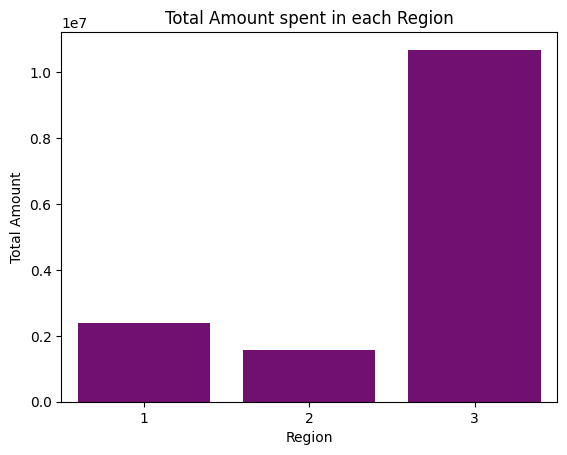

In [156]:
sns.barplot(data=region_spending, x='Region', y = 'Total_Spending' , color='purple')
plt.title("Total Amount spent in each Region")
plt.xlabel('Region')
plt.ylabel("Total Amount")
plt.show()

**What is the distribution of the columns?**

In [157]:
numeric_cols = ["Fresh", "Milk", "Grocery", "Frozen", "Detergents_Paper", "Delicassen"]

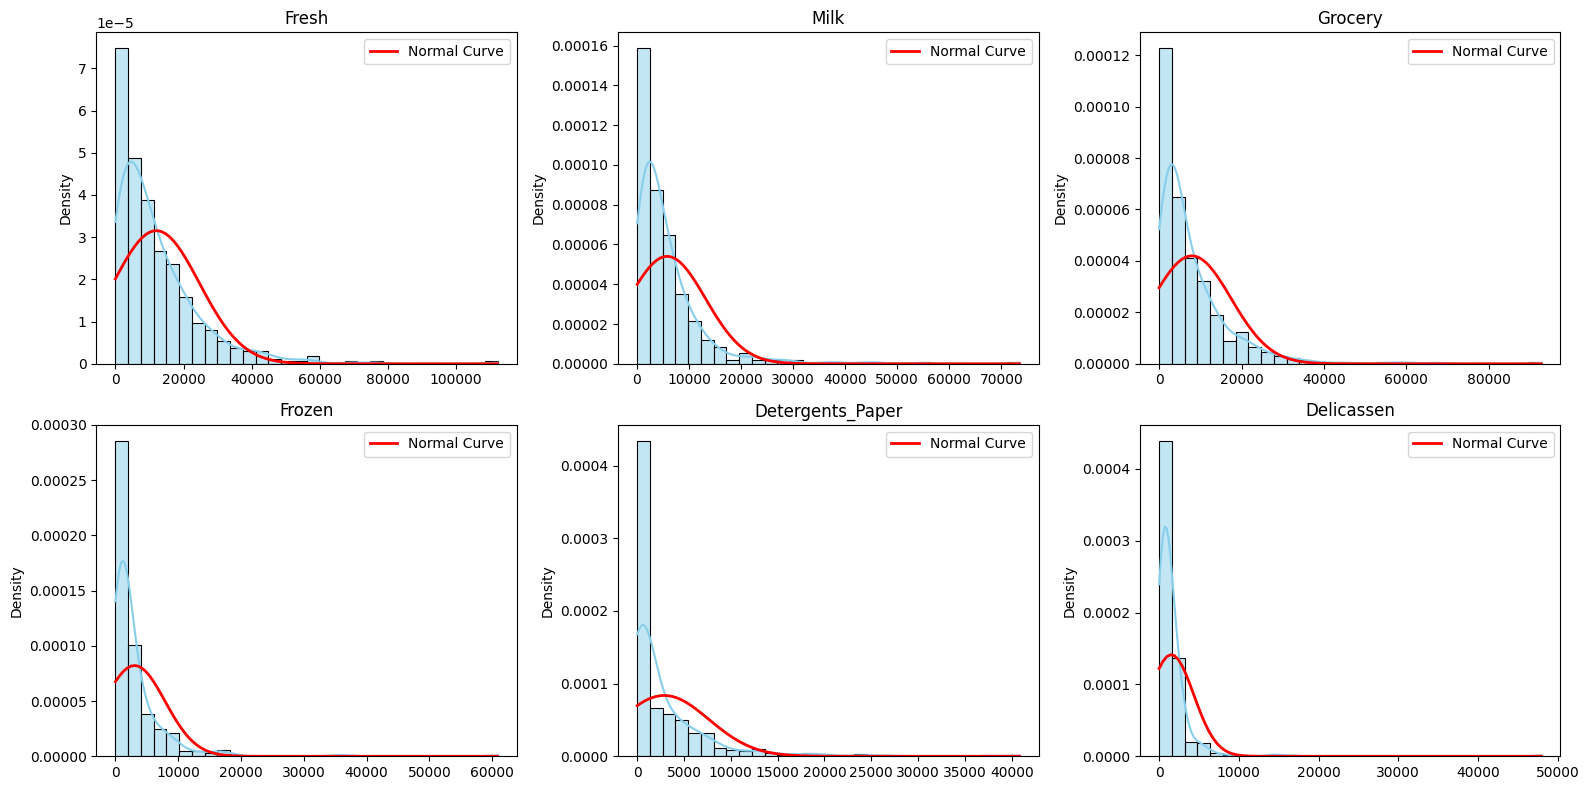

In [158]:
fig, axes = plt.subplots(2, 3, figsize=(16, 8))

for i, col in enumerate(numeric_cols):
    ax = axes[i//3, i%3]


    sns.histplot(df[col], bins=30, kde=True, stat="density", color="skyblue", ax=ax)

    mu, sigma = df[col].mean(), df[col].std()
    x = np.linspace(df[col].min(), df[col].max(), 100)
    ax.plot(x, stats.norm.pdf(x, mu, sigma), "r", linewidth=2, label="Normal Curve")

    ax.set_title(f"{col}")
    ax.set_xlabel("")
    ax.set_ylabel("Density")
    ax.legend()

plt.tight_layout()
plt.show()

**Data is skewed**

**Top 3 product categories in each Region**

In [159]:
#unpivot df from a "wide" format to a "long" format to check top 3 product categories
region_melted = (
    region_spending
    .drop(columns=["Total_Spending"], errors="ignore")  # drop the total spending so it wont be considered as product
    .reset_index()
    .melt(
        id_vars="Region",
        var_name="Product",
        value_name="Spending"
    )
)


In [160]:
top_products = (region_melted
                 .sort_values(["Region", "Spending"], ascending=[True, False]) #sort region in ascendinf order/ sort spending in descending order
                 .groupby("Region")
                 .head(3))

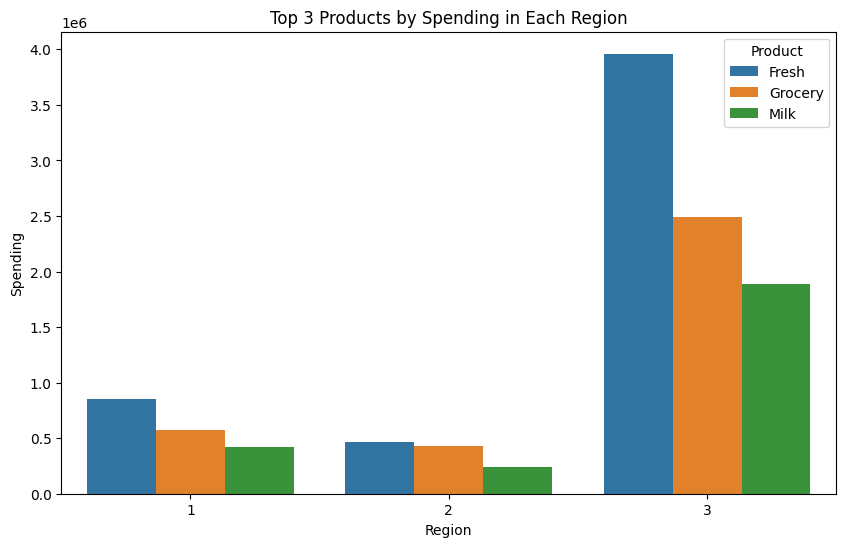

In [161]:
#Plot top 3 product category in each Region
plt.figure(figsize=(10,6))
sns.barplot(data=top_products, x="Region", y="Spending", hue="Product")
plt.title("Top 3 Products by Spending in Each Region")
plt.show()


**Check total amount spent on each channel**

In [162]:
channel_spending = df.groupby('Channel').agg({'Delicassen' : 'sum' ,  'Frozen' : 'sum', 'Detergents_Paper' : 'sum', 'Grocery' : 'sum', 'Milk' : 'sum', 'Fresh' : 'sum' }).reset_index()

In [163]:
channel_spending.head()

,Channel,Delicassen,Frozen,Detergents_Paper,Grocery,Milk,Fresh
0,1,421955,1116979,235587,1180717,1028614,4015717
1,2,248988,234671,1032270,2317845,1521743,1264414


In [164]:
channel_spending["Total_Spending"] = (
    channel_spending["Fresh"]
    + channel_spending["Milk"]
    + channel_spending["Grocery"]
    + channel_spending["Frozen"]
    + channel_spending["Detergents_Paper"]
    + channel_spending["Delicassen"]
)


In [165]:
channel_spending

,Channel,Delicassen,Frozen,Detergents_Paper,Grocery,Milk,Fresh,Total_Spending
0,1,421955,1116979,235587,1180717,1028614,4015717,7999569
1,2,248988,234671,1032270,2317845,1521743,1264414,6619931


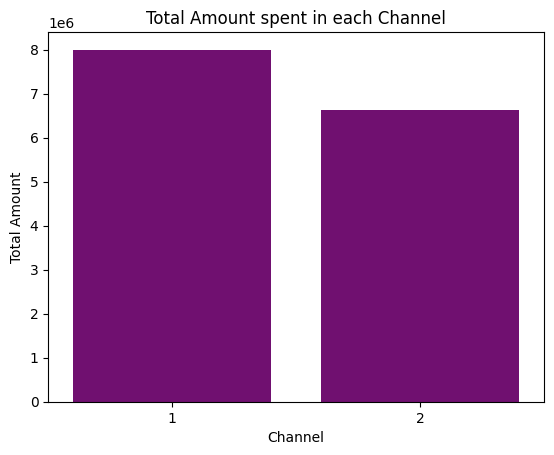

In [166]:
sns.barplot(data=channel_spending, x='Channel', y = 'Total_Spending' , color='purple')
plt.title("Total Amount spent in each Channel")
plt.xlabel('Channel')
plt.ylabel("Total Amount")
plt.show()

**Check correlation betweenn features**

<Axes: >

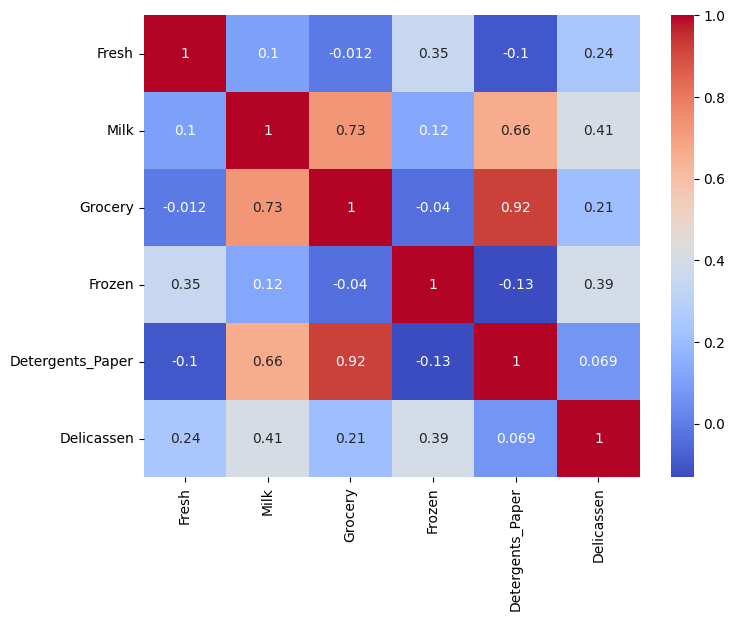

In [167]:
plt.figure(figsize=(8,6))
sns.heatmap(df[numeric_cols].corr(),
            annot=True, cmap="coolwarm")


**Check data distribution using boxplot**

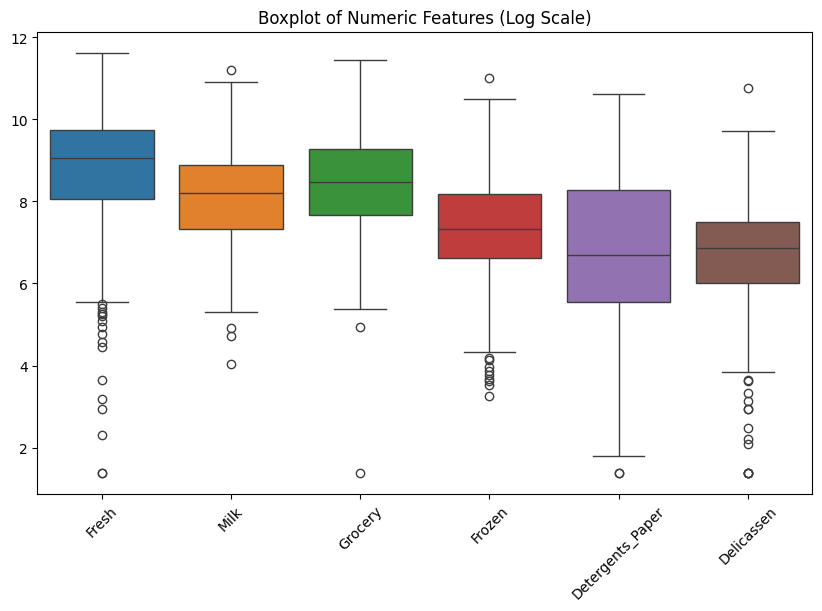

In [168]:
plt.figure(figsize=(10,6))
sns.boxplot(data=np.log1p(df[numeric_cols]))
plt.title("Boxplot of Numeric Features (Log Scale)")
plt.xticks(rotation=45)
plt.show()


# **Model Preprocessing**

In [169]:
df.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


In [170]:
#Check percentiles
percentiles = [0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99]

In [171]:
percentile_df = df[numeric_cols].quantile(percentiles).T
percentile_df

,0.01,0.05,0.25,0.50,0.75,0.95,0.99
Fresh,28.46,401.90,3127.75,8504.0,16933.75,36818.50,56082.61
Milk,255.56,593.75,1533.00,3627.0,7190.25,16843.40,37610.06
Grocery,259.82,851.45,2153.00,4755.5,10655.75,24033.50,43435.74
Frozen,43.95,136.85,742.25,1526.0,3554.25,9930.75,17964.82
Detergents_Paper,9.39,63.70,256.75,816.5,3922.00,12043.20,22571.61
Delicassen,7.39,63.95,408.25,965.5,1820.25,4485.40,8274.66


In [172]:
df_capped = df.copy()

In [173]:
#Cap at 1%–99%
for col in numeric_cols:
    lower = df_capped[col].quantile(0.01)
    upper = df_capped[col].quantile(0.99)
    df_capped[col] = df_capped[col].clip(lower, upper)

In [174]:
#Apply log transformation because data is skewed
df_log = df_capped.copy()
for col in numeric_cols:
    df_log[col] = np.log1p(df_log[col])

In [175]:
#Initialize Standard Scaler
scaler = StandardScaler()
df_scaled = pd.DataFrame(
    scaler.fit_transform(df_log),
    columns=df_log.columns
)


In [176]:
df_features = df_capped.copy()
df_features["Total_Spend"] = df_features.sum(axis=1)

for col in numeric_cols:
    df_features[f"{col}_Ratio"] = df_features[col] / df_features["Total_Spend"]

In [177]:
final_df = pd.concat([df_scaled, df_features[[c for c in df_features.columns if "_Ratio" in c]]], axis=1)


In [178]:
final_df.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Fresh_Ratio,Milk_Ratio,Grocery_Ratio,Frozen_Ratio,Detergents_Paper_Ratio,Delicassen_Ratio
0,1.448652,0.590668,0.499774,0.999755,0.457914,-1.532962,0.651735,0.424875,0.371340,0.283026,0.221620,0.006273,0.078377,0.039218
1,1.448652,0.590668,0.084384,1.014823,0.682014,0.138978,0.775412,0.651787,0.212107,0.294851,0.287578,0.052959,0.098975,0.053380
2,1.448652,0.590668,0.009782,0.912220,0.473275,0.386057,0.814334,1.842419,0.173508,0.240557,0.209859,0.065683,0.096026,0.214229
3,-0.690297,0.590668,0.532410,-0.988757,-0.096952,1.164057,-0.335307,0.657183,0.484389,0.043674,0.154135,0.233851,0.018514,0.065291
4,1.448652,0.590668,0.911149,0.448070,0.411081,0.773109,0.409042,1.510543,0.490511,0.117341,0.156122,0.084915,0.038542,0.112461


# **Models**

**Kmeans**

In [179]:
X = final_df[["Fresh", "Milk", "Grocery", "Frozen", "Detergents_Paper", "Delicassen"]]


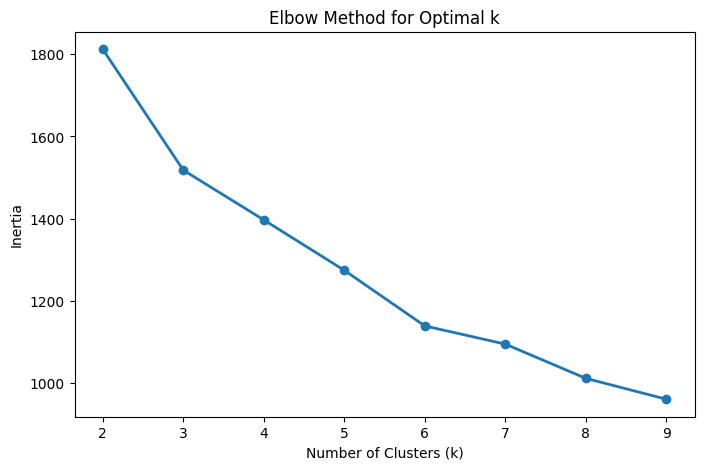

In [180]:
#Elbow method
inertia = []
K = range(2, 10)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8,5))
plt.plot(K, inertia, 'o-', linewidth=2)
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal k")
plt.xticks(K)
plt.show()


In [181]:
for k in range(2, 8):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X)
    sil = silhouette_score(X, labels)
    print(f"k={k}, silhouette={sil:.4f}")


k=2, silhouette=0.2945
k=3, silhouette=0.2654
k=4, silhouette=0.2099
k=5, silhouette=0.1660
k=6, silhouette=0.1870
k=7, silhouette=0.1680


In [182]:
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X)
final_df['Kmeans_Cluster'] = kmeans.predict(X)

**DBSCAN**

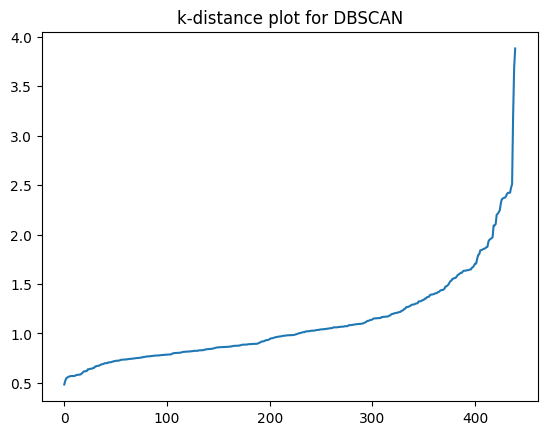

In [183]:
# Find eps using k-distance plot
neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(X)
distances, indices = neighbors_fit.kneighbors(X)

distances = np.sort(distances[:,4])
plt.plot(distances)
plt.title("k-distance plot for DBSCAN")
plt.show()


In [184]:
#Trying different numbers of eps and min samples
for eps in [0.5, 1, 2, 2.5]:
    for min_samples in [5, 7, 10, 15]:
        labels = DBSCAN(eps=eps, min_samples=min_samples).fit_predict(X)
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        print(f"eps={eps}, min_samples={min_samples}, clusters={n_clusters}")


eps=0.5, min_samples=5, clusters=1
eps=0.5, min_samples=7, clusters=0
eps=0.5, min_samples=10, clusters=0
eps=0.5, min_samples=15, clusters=0
eps=1, min_samples=5, clusters=3
eps=1, min_samples=7, clusters=2
eps=1, min_samples=10, clusters=1
eps=1, min_samples=15, clusters=1
eps=2, min_samples=5, clusters=1
eps=2, min_samples=7, clusters=1
eps=2, min_samples=10, clusters=1
eps=2, min_samples=15, clusters=1
eps=2.5, min_samples=5, clusters=1
eps=2.5, min_samples=7, clusters=1
eps=2.5, min_samples=10, clusters=1
eps=2.5, min_samples=15, clusters=1


In [185]:
# Train DBSCAN
clustering = DBSCAN(eps=1, min_samples=7).fit(X)
labels = clustering.labels_
final_df["DBSCAN_Cluster"] = labels

The data doesn’t have clear density-separated clusters, so DBSCAN is not a good fit here.

**Hierarchical Clustering**

Text(0, 0.5, 'Merge distance')

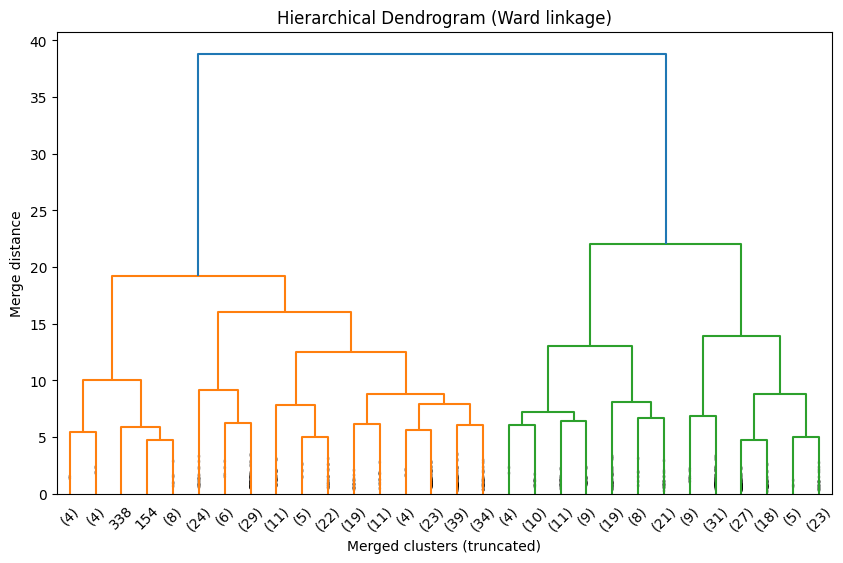

In [186]:
Z_ward = linkage(X.values, method='ward', metric='euclidean')

plt.figure(figsize=(10,6))
dendrogram(
    Z_ward,
    truncate_mode='lastp',
    p=30,
    leaf_rotation=45,
    show_contracted=True
)
plt.title("Hierarchical Dendrogram (Ward linkage)")
plt.xlabel("Merged clusters (truncated)")
plt.ylabel("Merge distance")

In [187]:
#Choose no of clusters = Choose the cut just before a big jump in height (20-38))
hierarchical_clustering = AgglomerativeClustering(n_clusters=2, metric='euclidean', linkage='ward')
final_df['hierarchical_cluster'] = hierarchical_clustering.fit_predict(X)

**Mean Shift**

In [188]:
for q in [0.1, 0.2, 0.3, 0.4]:
    bandwidth = estimate_bandwidth(X, quantile=q, n_samples=500)
    ms = MeanShift(bandwidth=bandwidth, bin_seeding=False)
    labels = ms.fit_predict(X)

    if len(np.unique(labels)) > 1:
        sil = silhouette_score(X, labels)
        ch = calinski_harabasz_score(X, labels)
        db = davies_bouldin_score(X, labels)
        print(f"Q={q}, Clusters={len(np.unique(labels))}, Sil={sil:.3f}, CH={ch:.1f}, DB={db:.3f}")

Q=0.1, Clusters=15, Sil=0.175, CH=33.1, DB=1.189
Q=0.2, Clusters=5, Sil=0.214, CH=22.4, DB=1.166
Q=0.3, Clusters=3, Sil=0.341, CH=16.5, DB=1.070
Q=0.4, Clusters=2, Sil=0.353, CH=10.6, DB=1.134


In [189]:
bandwidth = estimate_bandwidth(X, quantile=0.3, random_state=42) #radius of the window
ms = MeanShift(bandwidth=bandwidth, bin_seeding=False)
labels_ms = ms.fit_predict(X)

In [190]:
final_df['MeanShift_Cluster'] = labels_ms

# **Evaluation**

 Silhouette, Davies–Bouldin, Calinski–Harabasz.


In [191]:
#Calculate score for each algorithm
results = {}
models_cluster = final_df[["Kmeans_Cluster", "DBSCAN_Cluster", "hierarchical_cluster", "MeanShift_Cluster"]]
for col in models_cluster:
    labels = final_df[col]
    sil = silhouette_score(X, labels)
    db = davies_bouldin_score(X, labels)
    ch = calinski_harabasz_score(X, labels)
    results[col] = {"Silhouette": sil, "Davies-Bouldin": db, "Calinski-Harabasz": ch}



In [192]:
results_df = pd.DataFrame(results).T
print(results_df)

                      Silhouette  Davies-Bouldin  Calinski-Harabasz
Kmeans_Cluster          0.265356        1.331733         161.481701
DBSCAN_Cluster          0.048718        3.414790          15.780723
hierarchical_cluster    0.266387        1.428528         175.136615
MeanShift_Cluster       0.340800        1.070479          16.486287


**Silhouette Score**: <br>

MeanShift (0.341): best separation & cohesion (clusters are relatively compact and well separated).<br>

Hierarchical (0.266),  KMeans (0.265): moderate.<br>

DBSCAN (0.049): clusters are very weak, almost random.<br><br>

**Davies–Bouldin Index**: <br>

MeanShift (1.07): (clusters are well-separated). <br>

KMeans (1.33): moderate. <br>

Hierarchical (1.43): Slightly worse than KMeans.<br>

DBSCAN (3.41):clusters overlap heavily.<br><br>

**Calinski–Harabasz Index**: <br>
Hierarchical (175.1): best compact & separated clusters. <br>

KMeans (161.5): very close, also strong.<br>

MeanShift (16.5): weak.<br>

DBSCAN (15.8): weak.<br>

# **PCA / t-SNE**

**1) PCA**

In [193]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

final_df['PCA1'] = X_pca[:,0]
final_df['PCA2'] = X_pca[:,1]

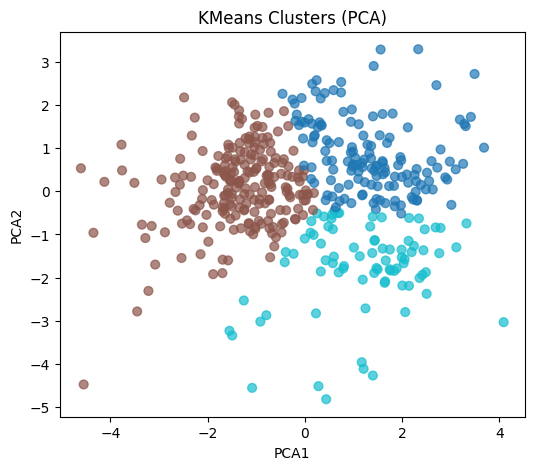

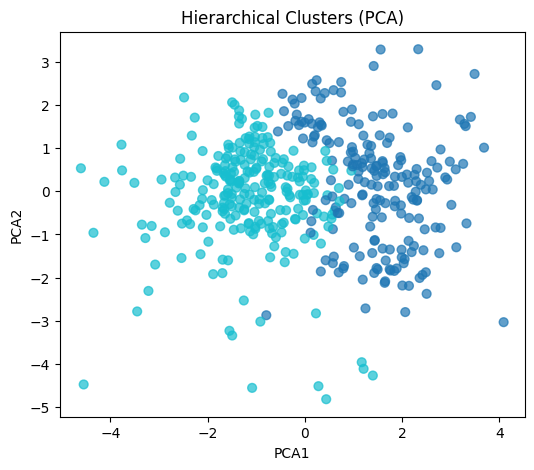

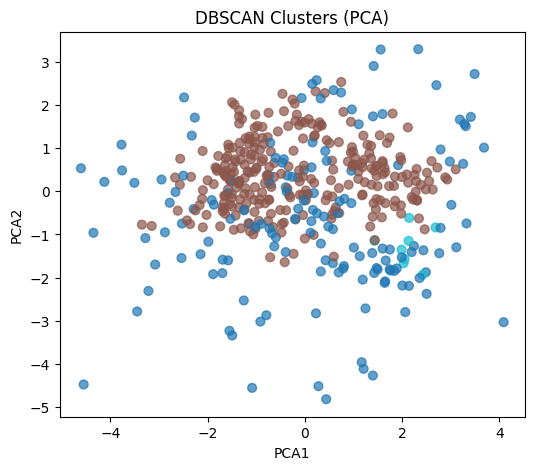

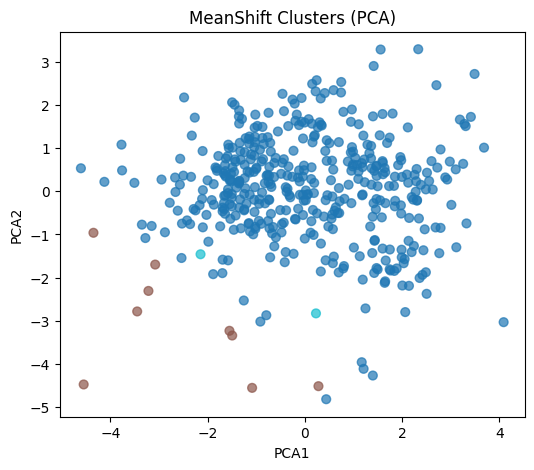

In [194]:
def plot_clusters_pca(df, cluster_col, title):
    plt.figure(figsize=(6,5))
    plt.scatter(df['PCA1'], df['PCA2'], c=df[cluster_col], cmap='tab10', s=40, alpha=0.7)
    plt.title(title)
    plt.xlabel("PCA1")
    plt.ylabel("PCA2")
    plt.show()

plot_clusters_pca(final_df, 'Kmeans_Cluster', "KMeans Clusters (PCA)")
plot_clusters_pca(final_df, 'hierarchical_cluster', "Hierarchical Clusters (PCA)")
plot_clusters_pca(final_df, 'DBSCAN_Cluster', "DBSCAN Clusters (PCA)")
plot_clusters_pca(final_df, 'MeanShift_Cluster', "MeanShift Clusters (PCA)")


**2) t-SNE**

In [195]:
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X)

final_df['tSNE1'] = X_tsne[:,0]
final_df['tSNE2'] = X_tsne[:,1]

In [196]:
def plot_clusters_tnse(df, cluster_col, title):
    plt.figure(figsize=(6,5))
    plt.scatter(df['tSNE1'], df['tSNE2'], c=df[cluster_col], cmap='tab10', s=40, alpha=0.7)
    plt.title(title)
    plt.xlabel("tSNE1")
    plt.ylabel("tSNE2")
    plt.show()

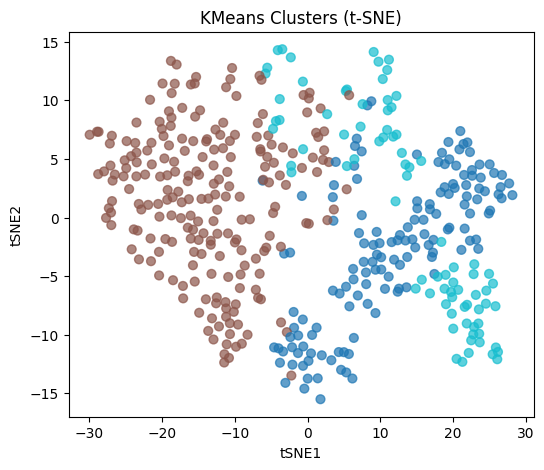

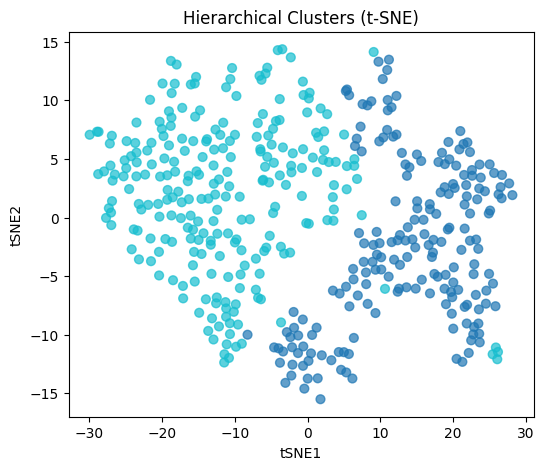

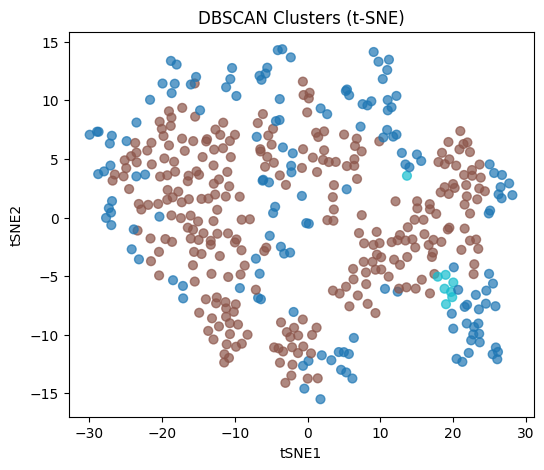

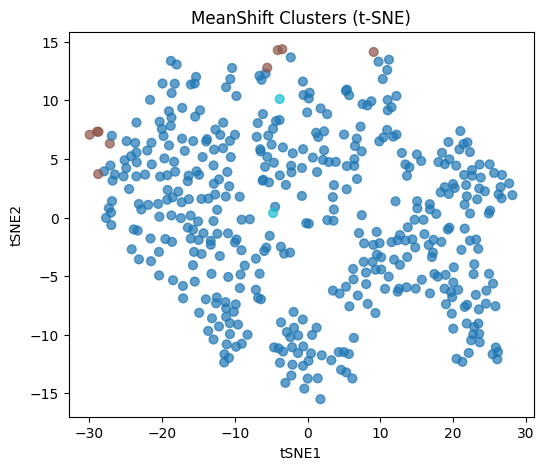

In [197]:
plot_clusters_tnse(final_df, 'Kmeans_Cluster', "KMeans Clusters (t-SNE)")
plot_clusters_tnse(final_df, 'hierarchical_cluster', "Hierarchical Clusters (t-SNE)")
plot_clusters_tnse(final_df, 'DBSCAN_Cluster', "DBSCAN Clusters (t-SNE)")
plot_clusters_tnse(final_df, 'MeanShift_Cluster', "MeanShift Clusters (t-SNE)")

# **Interpretation**

In [198]:
final_df.columns

Index(['Channel', 'Region', 'Fresh', 'Milk', 'Grocery', 'Frozen',
       'Detergents_Paper', 'Delicassen', 'Fresh_Ratio', 'Milk_Ratio',
       'Grocery_Ratio', 'Frozen_Ratio', 'Detergents_Paper_Ratio',
       'Delicassen_Ratio', 'Kmeans_Cluster', 'DBSCAN_Cluster',
       'hierarchical_cluster', 'MeanShift_Cluster', 'PCA1', 'PCA2', 'tSNE1',
       'tSNE2'],
      dtype='object')

In [199]:
cluster_profiles = final_df.groupby("Kmeans_Cluster")[["Fresh_Ratio", "Milk_Ratio", "Grocery_Ratio", "Frozen_Ratio", "Detergents_Paper_Ratio", "Delicassen_Ratio"]].mean()

In [200]:
cluster_profiles

,Fresh_Ratio,Milk_Ratio,Grocery_Ratio,Frozen_Ratio,Detergents_Paper_Ratio,Delicassen_Ratio
Kmeans_Cluster,,,,,,
0,0.311832,0.199636,0.263954,0.073306,0.098010,0.053160
1,0.517126,0.114796,0.138437,0.155103,0.024992,0.049304
2,0.111557,0.255109,0.412742,0.027426,0.162733,0.030231


**Cluster 0** <br>


*   Fresh = 31%, Grocery = 26%, Milk = 20%, rest are moderate.
*   Balanced shoppers: buy fresh items, groceries, and milk regularly.
*   Could be households with mixed needs.


**Cluster 1** <br>


*   Fresh = 52%, Frozen = 15%, very low Grocery (14%) and Milk (11%).
*   Mostly buying fresh and frozen.
*   Likely restaurants / cafes.


**Cluster 2**


*   Grocery = 41%, Milk = 25%, Detergents_Paper = 16%, very low fresh (11%).
*   Focus on grocery staples + household supplies.
*   Likely retailers / convenience stores.
























